# 第8章:ニューラルネット

## 70.単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xi
の特徴ベクトルxi
を並べた行列X
と，正解ラベルを並べた行列（ベクトル）Y
を作成したい．

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./NewsAggregatorDataset/newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [2]:
import gdown
from gensim.models import KeyedVectors

# ダウンロードファイルのロード  #単語ベクトルを読み込む
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
import string
import torch

def transform_w2v(text):    #string.punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table).split()  # string.punctuationをスペースに置換後、スペースで分割してリスト化
    vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

    return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [4]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[-0.0170,  0.1318, -0.0728,  ...,  0.0395,  0.0223,  0.0184],
        [-0.1119, -0.0523, -0.1002,  ...,  0.0319, -0.0237, -0.0425],
        [-0.0636, -0.0228, -0.0005,  ..., -0.0280,  0.1057,  0.0396],
        ...,
        [ 0.0301, -0.0355, -0.0082,  ..., -0.0045,  0.0606, -0.0281],
        [ 0.0002,  0.0442, -0.0424,  ..., -0.0507,  0.0283,  0.0365],
        [ 0.0242,  0.0418,  0.1211,  ..., -0.0564,  0.0144,  0.0277]])


In [5]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10672])
tensor([0, 0, 0,  ..., 0, 2, 2])


In [6]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

## 71.単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

In [7]:
from torch import nn

class SLPNet(nn.Module): #単層ニューラルネットワークを定義
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)   #ネットワーク層
        nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

    def forward(self, x):   #順伝播で通るレイヤーを配置
        x = self.fc(x)
        return x

In [8]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化   #定義したモデルを初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)      #題の計算
print(y_hat_1.size())
print(y_hat_1)

torch.Size([1, 4])
tensor([[0.9240, 0.0202, 0.0200, 0.0358]], grad_fn=<SoftmaxBackward0>)


In [9]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)   #dim=-1 最後の次元の要素の和が1になる
print(Y_hat.size())
print(Y_hat)

torch.Size([4, 4])
tensor([[0.9240, 0.0202, 0.0200, 0.0358],
        [0.0220, 0.1481, 0.2186, 0.6113],
        [0.0313, 0.0629, 0.6321, 0.2737],
        [0.3275, 0.2026, 0.0909, 0.3791]], grad_fn=<SoftmaxBackward0>)


## 72.損失と勾配の計算

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')
print("-------------------------------")
print(model(X_train[:1]))
print(y_train[:1])

損失: 0.0791
勾配:
tensor([[ 0.0013, -0.0100,  0.0055,  ..., -0.0030, -0.0017, -0.0014],
        [-0.0003,  0.0027, -0.0015,  ...,  0.0008,  0.0005,  0.0004],
        [-0.0003,  0.0026, -0.0015,  ...,  0.0008,  0.0004,  0.0004],
        [-0.0006,  0.0047, -0.0026,  ...,  0.0014,  0.0008,  0.0007]])
-------------------------------
tensor([[ 3.1046, -0.7178, -0.7263, -0.1470]], grad_fn=<MmBackward0>)
tensor([0])


In [12]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 2.1192
勾配:
tensor([[ 0.0477, -0.0092,  0.0270,  ..., -0.0022, -0.0185, -0.0003],
        [-0.0066,  0.0059, -0.0044,  ...,  0.0011,  0.0004, -0.0006],
        [-0.0169, -0.0024, -0.0061,  ..., -0.0024,  0.0153,  0.0041],
        [-0.0242,  0.0057, -0.0166,  ...,  0.0036,  0.0028, -0.0032]])


## 73.確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [13]:
from torch.utils.data import Dataset

# 特徴ベクトルとラベルベクトルを合わせて保持することができる型
class NewsDataset(Dataset):
    def __init__(self, X, y):  # datasetの構成要素を指定
        self.X = X
        self.y = y

    def __len__(self):  # len(dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, idx):  # dataset[idx]で返す値を指定
        return [self.X[idx], self.y[idx]]

In [14]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
#batch_sizeのデータを取り出す
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [15]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義 #最適化
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
    # 訓練モードに設定
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        # 勾配をゼロで初期化
        optimizer.zero_grad()

        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 損失を記録
        loss_train += loss.item()

    # バッチ単位の平均損失計算   #1epochごと?
    loss_train = loss_train / i
    print(i)

    # 検証データの損失計算
    model.eval() 
    with torch.no_grad():   #検証なので学習時とは違い勾配計算不要、テンソルの勾配計算を不可にしてメモリの消費を減らす
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

10671
epoch: 1, loss_train: 0.4856, loss_valid: 0.3718
10671
epoch: 2, loss_train: 0.3184, loss_valid: 0.3261
10671
epoch: 3, loss_train: 0.2882, loss_valid: 0.3066
10671
epoch: 4, loss_train: 0.2736, loss_valid: 0.2969
10671
epoch: 5, loss_train: 0.2623, loss_valid: 0.2896
10671
epoch: 6, loss_train: 0.2556, loss_valid: 0.2869
10671
epoch: 7, loss_train: 0.2496, loss_valid: 0.2815
10671
epoch: 8, loss_train: 0.2456, loss_valid: 0.2852
10671
epoch: 9, loss_train: 0.2422, loss_valid: 0.2768
10671
epoch: 10, loss_train: 0.2386, loss_valid: 0.2828


## 74.正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [16]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:  #dataloaderから
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)    #予測ラベル
            #print(outputs)
            total += len(inputs)    #母数
            correct += (pred == labels).sum().item()
            #print(pred)

    return correct / total

In [17]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.922
正解率（評価データ）：0.910


## 75.損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [18]:
def calculate_loss_and_accuracy(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():      #勾配計算不要
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)     #予測ラベル
            total += len(inputs)      #分母
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total     #平均

In [19]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義  #確率的勾配降下法
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
        # 勾配をゼロで初期化
        optimizer.zero_grad()

        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train]) #プロット用
    log_valid.append([loss_valid, acc_valid])

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3361, accuracy_train: 0.8869, loss_valid: 0.3659, accuracy_valid: 0.8733
epoch: 2, loss_train: 0.2942, accuracy_train: 0.9008, loss_valid: 0.3217, accuracy_valid: 0.8846
epoch: 3, loss_train: 0.2748, accuracy_train: 0.9069, loss_valid: 0.3029, accuracy_valid: 0.8883
epoch: 4, loss_train: 0.2603, accuracy_train: 0.9129, loss_valid: 0.2914, accuracy_valid: 0.8981
epoch: 5, loss_train: 0.2540, accuracy_train: 0.9128, loss_valid: 0.2867, accuracy_valid: 0.8966
epoch: 6, loss_train: 0.2475, accuracy_train: 0.9158, loss_valid: 0.2830, accuracy_valid: 0.8981
epoch: 7, loss_train: 0.2467, accuracy_train: 0.9141, loss_valid: 0.2787, accuracy_valid: 0.9010
epoch: 8, loss_train: 0.2396, accuracy_train: 0.9189, loss_valid: 0.2735, accuracy_valid: 0.9070
epoch: 9, loss_train: 0.2353, accuracy_train: 0.9191, loss_valid: 0.2740, accuracy_valid: 0.9025
epoch: 10, loss_train: 0.2322, accuracy_train: 0.9215, loss_valid: 0.2722, accuracy_valid: 0.9078
epoch: 11, loss_train: 0.2282

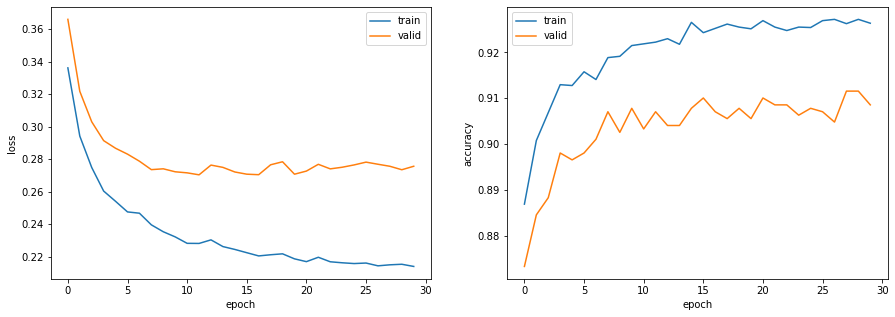

In [20]:
import numpy as np
from matplotlib import pyplot as plt

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()    #凡例
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()   #グラフ表示

## 76.チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [21]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
        # 勾配をゼロで初期化
        optimizer.zero_grad()

        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    #log_train.append([loss_train, acc_train])
    #log_valid.append([loss_valid, acc_valid])

    # ☆チェックポイントの保存   #学習パラメータの保存    model.state_dict()がモデルのパラメータの状態
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3298, accuracy_train: 0.8847, loss_valid: 0.3444, accuracy_valid: 0.8711
epoch: 2, loss_train: 0.2919, accuracy_train: 0.8992, loss_valid: 0.3108, accuracy_valid: 0.8898
epoch: 3, loss_train: 0.2686, accuracy_train: 0.9074, loss_valid: 0.2892, accuracy_valid: 0.8958
epoch: 4, loss_train: 0.2586, accuracy_train: 0.9102, loss_valid: 0.2822, accuracy_valid: 0.8996
epoch: 5, loss_train: 0.2503, accuracy_train: 0.9155, loss_valid: 0.2757, accuracy_valid: 0.9010
epoch: 6, loss_train: 0.2457, accuracy_train: 0.9156, loss_valid: 0.2707, accuracy_valid: 0.8988
epoch: 7, loss_train: 0.2385, accuracy_train: 0.9204, loss_valid: 0.2707, accuracy_valid: 0.8996
epoch: 8, loss_train: 0.2369, accuracy_train: 0.9179, loss_valid: 0.2688, accuracy_valid: 0.9033
epoch: 9, loss_train: 0.2328, accuracy_train: 0.9206, loss_valid: 0.2694, accuracy_valid: 0.9010
epoch: 10, loss_train: 0.2294, accuracy_train: 0.9204, loss_valid: 0.2653, accuracy_valid: 0.9048


## 77.ミニバッチ化
問題76のコードを改変し，  
B事例ごとに損失・勾配を計算し，行列  
Wの値を更新せよ（ミニバッチ化）．  
Bの値を1,2,4,8,…  
と変化させながら，1エポックの学習に要する時間を比較せよ．  

In [22]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
    # ☆dataloaderの作成  　データのロード batch_sizeを引数とする
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for inputs, labels in dataloader_train:
            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
        #log_train.append([loss_train, acc_train])
        #log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [23]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# ☆モデルの学習  バッチサイズを変えながら、1エポックごとに学習
for batch_size in [2 ** i for i in range(11)]:
    print(f'バッチサイズ: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3346, accuracy_train: 0.8864, loss_valid: 0.3491, accuracy_valid: 0.8793, 2.8286sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3072, accuracy_train: 0.8969, loss_valid: 0.3232, accuracy_valid: 0.8861, 1.5966sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2970, accuracy_train: 0.9010, loss_valid: 0.3125, accuracy_valid: 0.8853, 0.8996sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2934, accuracy_train: 0.9019, loss_valid: 0.3091, accuracy_valid: 0.8891, 0.5453sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2913, accuracy_train: 0.9029, loss_valid: 0.3076, accuracy_valid: 0.8906, 0.3666sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2909, accuracy_train: 0.9030, loss_valid: 0.3071, accuracy_valid: 0.8906, 0.2762sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2901, accuracy_train: 0.9034, loss_valid: 0.3068, accuracy_valid: 0.8913, 0.2360sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2892, accuracy_train: 0.9034, loss_valid: 0.3066, accuracy_valid: 0.8921, 0.2070sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2911, accuracy_

## 78.GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ.

In [24]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():   #勾配計算不要
        for inputs, labels in loader:
            inputs = inputs.to(device)   #GPUに送る
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    # ☆GPUに送る
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for inputs, labels in dataloader_train:
            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()
    
        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [25]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# ☆デバイスを指定
device = torch.device('cuda')
#device = torch.device('cuda:1')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
    print(f'バッチサイズ: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3366, accuracy_train: 0.8797, loss_valid: 0.3604, accuracy_valid: 0.8748, 6.4549sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3049, accuracy_train: 0.8951, loss_valid: 0.3281, accuracy_valid: 0.8868, 3.7473sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2955, accuracy_train: 0.8987, loss_valid: 0.3180, accuracy_valid: 0.8906, 1.9857sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2918, accuracy_train: 0.8995, loss_valid: 0.3150, accuracy_valid: 0.8906, 1.0298sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2899, accuracy_train: 0.9016, loss_valid: 0.3130, accuracy_valid: 0.8921, 0.5496sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2887, accuracy_train: 0.9016, loss_valid: 0.3121, accuracy_valid: 0.8928, 0.3241sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2885, accuracy_train: 0.9020, loss_valid: 0.3118, accuracy_valid: 0.8928, 0.2062sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2870, accuracy_train: 0.9017, loss_valid: 0.3115, accuracy_valid: 0.8921, 0.1460sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2885, accuracy_

## 79.多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [26]:
from torch.nn import functional as F

#3層のニューラルネットワーク
class MLPNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size, mid_layers):     #次元の数
        super().__init__()
        self.mid_layers = mid_layers
        self.fc = nn.Linear(input_size, mid_size)      #入力層
        self.fc_mid = nn.Linear(mid_size, mid_size)    #中間層
        self.fc_out = nn.Linear(mid_size, output_size)    #出力層
        self.bn = nn.BatchNorm1d(mid_size)      #バッチノーマライゼーション：学習をより高速にかつ安定に

    def forward(self, x):
        x = F.relu(self.fc(x))    #入力層の出力
        for _ in range(self.mid_layers):    #中間層が複数ある時に各々学習させるため(?)
            x = F.relu(self.bn(self.fc_mid(x))) #中間層の出力  #中間層の学習の後にバッチノーマライゼーション
            x = F.relu(self.fc_out(x))    #最終層の出力

        return x #最終層の出力

In [27]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    # GPUに送る
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    # スケジューラの設定
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for inputs, labels in dataloader_train:
            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        # ☆検証データの損失が3エポック連続で低下しなかった場合は学習終了
        if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
            break

        # ☆スケジューラを1ステップ進める    スケジューラ：学習率を調整　学習率：最適化においてどのくらいの値を動かすか？ 大きいと発散し、小さいと収束に時間がかかる
        scheduler.step()

    return {'train': log_train, 'valid': log_valid}

In [28]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 0.8539, accuracy_train: 0.7529, loss_valid: 0.8754, accuracy_valid: 0.7481, 0.6213sec
epoch: 2, loss_train: 0.7095, accuracy_train: 0.7695, loss_valid: 0.7355, accuracy_valid: 0.7616, 0.6076sec
epoch: 3, loss_train: 0.6429, accuracy_train: 0.7761, loss_valid: 0.6712, accuracy_valid: 0.7661, 0.5896sec
epoch: 4, loss_train: 0.6086, accuracy_train: 0.7819, loss_valid: 0.6379, accuracy_valid: 0.7811, 0.6040sec
epoch: 5, loss_train: 0.5815, accuracy_train: 0.7874, loss_valid: 0.6107, accuracy_valid: 0.7789, 0.6657sec
epoch: 6, loss_train: 0.5571, accuracy_train: 0.7965, loss_valid: 0.5867, accuracy_valid: 0.7931, 0.5812sec
epoch: 7, loss_train: 0.5357, accuracy_train: 0.8052, loss_valid: 0.5649, accuracy_valid: 0.7991, 0.5864sec
epoch: 8, loss_train: 0.5184, accuracy_train: 0.8157, loss_valid: 0.5480, accuracy_valid: 0.8096, 0.5966sec
epoch: 9, loss_train: 0.4992, accuracy_train: 0.8250, loss_valid: 0.5281, accuracy_valid: 0.8171, 0.6798sec
epoch: 10, loss_train: 0.477

epoch: 77, loss_train: 0.1953, accuracy_train: 0.9379, loss_valid: 0.2497, accuracy_valid: 0.9123, 0.6167sec
epoch: 78, loss_train: 0.1928, accuracy_train: 0.9393, loss_valid: 0.2474, accuracy_valid: 0.9153, 0.5942sec
epoch: 79, loss_train: 0.1924, accuracy_train: 0.9397, loss_valid: 0.2476, accuracy_valid: 0.9123, 0.6604sec
epoch: 80, loss_train: 0.1911, accuracy_train: 0.9398, loss_valid: 0.2470, accuracy_valid: 0.9153, 0.6668sec
epoch: 81, loss_train: 0.1896, accuracy_train: 0.9399, loss_valid: 0.2469, accuracy_valid: 0.9145, 0.6249sec
epoch: 82, loss_train: 0.1884, accuracy_train: 0.9407, loss_valid: 0.2467, accuracy_valid: 0.9153, 0.7369sec
epoch: 83, loss_train: 0.1877, accuracy_train: 0.9404, loss_valid: 0.2469, accuracy_valid: 0.9130, 0.6091sec
epoch: 84, loss_train: 0.1859, accuracy_train: 0.9394, loss_valid: 0.2458, accuracy_valid: 0.9145, 0.6070sec
epoch: 85, loss_train: 0.1853, accuracy_train: 0.9414, loss_valid: 0.2451, accuracy_valid: 0.9175, 0.6679sec
epoch: 86, loss_tra

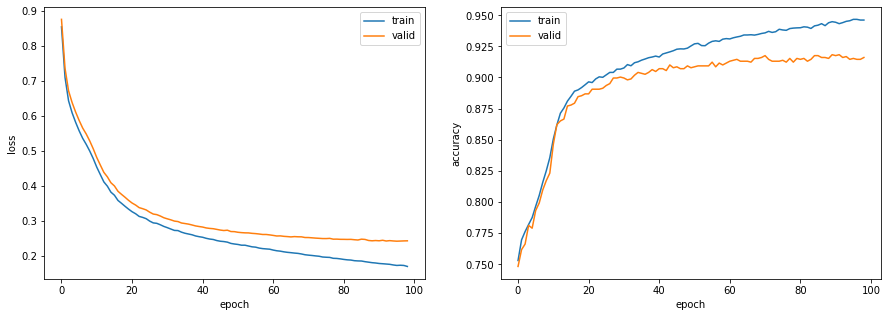

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [30]:
def calculate_accuracy(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

    return correct / total

In [31]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.946
正解率（評価データ）：0.910


In [32]:
#正解率（評価データ）：0.907